In [1]:
from __future__ import division
import AudioLoad
import AudioFeatures
import AudioActDet
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
import pandas as pd
%matplotlib inline
import math
import random
import sys
from numpy.linalg import inv
from scipy.stats import multivariate_normal as mvn
from operator import itemgetter 
from collections import Counter

In [2]:
SegClass = pickle.load(open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'rb'))
VADClass = pickle.load(open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'rb'))
FeatureClass = pickle.load(open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'rb'))
AudioClass = pickle.load(open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'rb'))

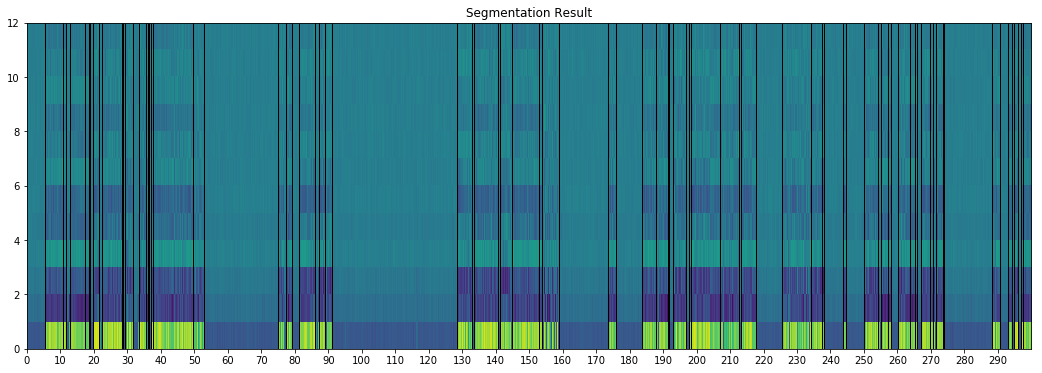

In [3]:
segTime, deadTime = SegClass.Visualizer(tmin = 0, 
                                        tmax = 300, 
                                        AudioFeatures = FeatureClass, 
                                        AudioActDet = VADClass, 
                                        xticks_gap = 10, 
                                        final = True)

In [4]:
SegIdx2d = SegClass.getResult(AudioActDet = VADClass, minDuration_sec = 0.2)

In [5]:
features = FeatureClass.FeatureExtraction(highest_order = 2, 
                                          num_cep = 12, 
                                          lifting = True, 
                                          lifting_coef = 22, 
                                          mean_normalization = True, 
                                          nshift = 2)

In [8]:
def single_gau(matrix):
    """Calculate the determinant of feature matrix in BIC distance"""
    cov=np.cov(matrix)
    det = np.linalg.det(cov) + 1e-13
    return np.log(det)

In [9]:
def bicdist(x,y,lf):
    # lf is lambda which is free design para. dependent on the data
    z=np.concatenate((x,y),axis=1)
    xn = x.shape[1]
    yn = y.shape[1]
    zn = z.shape[1]
    
    # 36 is the number of acoustic vectors, # of free parameters to estimate the model
    p = 0.5*(36+0.5*36*(36+1))*(np.log(zn))
    bic= 0.5 * (zn *single_gau(z)- xn * single_gau(x) - yn * single_gau(y)) - lf * p

    return bic

In [10]:
def lldist(x,y,lf):
    d = x.shape[0]
    z = np.concatenate((x,y),axis = 1)
    zn = z.shape[1]
    L0 = np.sum(mvn.logpdf(z.T, mean = z.mean(axis = 1), cov = np.cov(z), allow_singular=True))
    L0 += lf/2 * (d + d * (d + 1) / 2) * np.log(zn)
    
    L1_x = np.sum(mvn.logpdf(x.T, mean = x.mean(axis = 1), cov = np.cov(x), allow_singular=True))
    L1_y = np.sum(mvn.logpdf(y.T, mean = y.mean(axis = 1), cov = np.cov(y), allow_singular=True))
    
    dist = L1_x + L1_y - L0
    return dist

In [11]:
def HCluster(act_segs, lf=1):
    #global route_dic
    chunklen = len(act_segs)
    count = 0
    print(str(len(act_segs))+' Segments')
    count1 = 0
    disact = []
    diry_dist = {}
    dismin = []
    merge_idx_1 = []
    merge_idx_2 = []
    
    while((len(act_segs)>1)):
        si_idx =[]
        sj_idx=[]
        dist=[]

        for i in range(len(act_segs)-1):
            for j in range(i+1, len(act_segs)):
                if (i not in merge_idx_1) and (j not in merge_idx_1) and (i not in merge_idx_2) and (j not in merge_idx_2):
                    pair = str(i)+'_'+str(j)
            
                    ## Avoid repeat calculation
                    if pair in diry_dist:
                        dist.append(diry_dist[pair])
                    else:
                        caldist = lldist(act_segs[i],act_segs[j], lf)
                        diry_dist.update({pair:caldist})
                        dist.append(diry_dist[pair])
                    si_idx.append(i)
                    sj_idx.append(j)
            count = count + 1
        if (len(dist) == 0):
            break
    
    # Merge!
    # 找出bic最小 －> bic 最小的index -> 从index找原来的元素
        dis = min(dist)
        dismin.append(dis)
    #print ('BIC SCORE ' + str(dis))
        disact.append(dis)
        mindis_idx = dist.index(dis)
        s1 = si_idx[mindis_idx]
        s2 = sj_idx[mindis_idx]
        merge_idx_1.append(s1)
        merge_idx_2.append(s2)

        #print('Merge: '+ str (s1) + ' & ' + str(s2))
        merge_clus = np.concatenate((act_segs[s1], act_segs[s2]), axis = 1)
    
        # Update clusters
        act_segs.append(merge_clus)
    
        count1=count1+1
        #print count1
        c = len(act_segs) - 2*count1 + 1
        #print('-------Clusters Remain '+str(c))
        
        # Figure out the cut-off index
    r2s = []
    for k in range(len(dismin)-1):
        r2 = dismin[k+1] / dismin[k]
        if (r2 > 0.5) & (r2 < 1.5):
            r2s.append(r2)
        else:
            break
    r_max = max(r2s)
    r_2max = sorted(r2s)[-2]
    r_midx = r2s.index(r_max)
    r_2midx = r2s.index(r_2max)
    if r_max > 1.15 * r_2max:
        r_idx = r_midx
    else:
        r_idx  = min(r_midx, r_2midx)
    
    act_segs_clu = []
    iteration = pd.DataFrame.from_items([('Ele_1', merge_idx_1), ('Ele_2',merge_idx_2)])
    iteration['Ele_mer'] = range(chunklen, 2*chunklen -1, 1) #(# of clusters, 2* # of clusters -1, 1)
    if r_idx == 0:
        route_dic = {}
        route_0 = [iteration.iloc[0][0], iteration.iloc[0][1]]
        route_dic.update({chunklen: route_0})
    else:
        iteration = iteration[:r_idx]
        route_dic = {}
        route_0 = [iteration.iloc[0][0], iteration.iloc[0][1]]
        route_dic.update({chunklen: route_0})
        for i in range(1,len(iteration)):
            if (iteration.iloc[i][0] < chunklen) and (iteration.iloc[i][1] < chunklen):
                route = [iteration.iloc[i][0], iteration.iloc[i][1]]
                route_dic.update({iteration.iloc[i][2]: route})
            if (iteration.iloc[i][0] < chunklen) and (iteration.iloc[i][1] > chunklen-1):
                route = route_dic[iteration.iloc[i][1]] + [iteration.iloc[i][0]]
                route_dic.update({iteration.iloc[i][2]: route})
                del route_dic[iteration.iloc[i][1]]
            if (iteration.iloc[i][0] > chunklen -1) and (iteration.iloc[i][1] > chunklen -1):
                route = route_dic[iteration.iloc[i][0]] + route_dic[iteration.iloc[i][1]]
                route_dic.update({iteration.iloc[i][2]:route})
                del route_dic[iteration.iloc[i][0]]
                del route_dic[iteration.iloc[i][1]]
        
    already_clu = []
    for i in route_dic.keys():
        already_clu += (route_dic[i])
        for j in range(len(route_dic[i])):
            if j == 0:
                cluster = act_segs[route_dic[i][j]]
            else:
                cluster = np.concatenate((cluster, act_segs[route_dic[i][j]]), axis = 1)
        act_segs_clu.append(cluster)
    single_clu = list(set(range(chunklen)) - set(already_clu))
    for k in single_clu:
        act_segs_clu.append(act_segs[k])
    
    #print Pur(route_dic, total_point = chunklen)
            
    #else:
     #   act_segs_clu = act_segs_clu + act_segs[0:chunklen]
        
    return act_segs, act_segs_clu, route_dic

In [13]:
def within_HC(feature_segments, cutk = 40):
    """cutk is the chunk size"""
    chunks = [feature_segments[x: x+cutk] for x in range(0, len(feature_segments), cutk)]
    if len(chunks[len(chunks)-1]) < cutk-10:
        chunks[len(chunks)-2] = chunks[len(chunks)-2] + chunks[len(chunks)-1]
        del chunks[-1]
    print str(len(feature_segments)) + " segments in total"
    print str(len(chunks)) + " Chunks"
    print "The last chunk has " + str(len(chunks[-1])) + " segments"
    print "-----------------------------------------"
    
    new_segs = []
    big_dict = {}
    upidx = 0
    for i in range(len(chunks)):
        new_segment, act_segs_clu, chunk_dic = HCluster(chunks[i])
        new_segs = new_segs + act_segs_clu
        already_clu = []
        for j in chunk_dic.keys():
            already_clu += (chunk_dic[j])
            big_dict.update({upidx: map(lambda x: x + cutk*i, chunk_dic[j])})
            upidx += 1
        single_clu = list(set(range(int((len(chunks[i])+1)/2))) - set(already_clu))
        for k in single_clu:
            big_dict.update({upidx: [k + cutk*i]})
            upidx +=1
    
    print str(len(new_segs)) + " Speakers"
    #print Pur(big_dict)
    print "*******************************************************************"
    return new_segs, big_dict

In [14]:
def Evaluation(track_dict, total_point = len(act_segs_all)):
    pur = 0
    N = 0
    fe = []
    for i in track_dict.keys():
        cluster = seg_copy[sorted(track_dict[i])]
        cluster_res = []
        for j in cluster:
            found = np.where((j[0] >= gt_copy.start_GT - 0.1) & (j[1] <= gt_copy.end_GT + 0.1))
            if len(found[0]) == 0:
                cluster_res.append(999)
            elif len(found[0]) == 1:
                cluster_res.append(gt_copy.iloc[found[0][0]].Speaker.item())
                fe.append(found[0][0])
            else:
                cluster_res.append(gt_copy.iloc[found[0][0]].Speaker.item())
                fe.append(found[0][0])
                fe.append(found[0][1])
        count_dict = Counter(cluster_res)
        pur += max(count_dict.values())
        N += np.sum(sorted(count_dict.values())[:-1])
    purity = pur/total_point
    misc = (len(gt_copy) - len(fe)) / N
    misc_sum = ((len(gt_copy) - len(fe)) + N) / total_point
    return purity, misc, misc_sum

# Run Code

In [16]:
# Break features as seperate segments
act_segs_all = []
for i in SegIdx2d:
    act_seg = features[:,i[0]:i[1]]
    act_segs_all.append(act_seg)

In [17]:
act_segs = act_segs_all

In [18]:
gt = pd.read_csv('/Users/dl/GSR/Audio/GTResults.csv')
gt_copy = gt.loc[gt.Speaker != 0].reset_index(drop = 1)
seg_copy = SegIdx2d.copy()/SegClass.sec_to_bin

In [19]:
hsegs, ls_dict = within_HC(act_segs,20)
print "purity: " + str(Evaluation(ls_dict)[0])
print "misclf: " + str(Evaluation(ls_dict)[1])
print "misclf_sum: " + str(Evaluation(ls_dict)[2])
while((len(hsegs)>100)):
    hsegs, new_dict = within_HC(hsegs,20)
    for k, v in new_dict.items():
        new_dict[k] = [item for sublist in [ls_dict[x] for x in v] for item in sublist]
    ls_dict = new_dict
    print "purity: " + str(Evaluation(ls_dict)[0])
    print "misclf: " + str(Evaluation(ls_dict)[1])
    print "misclf_sum: " + str(Evaluation(ls_dict)[2])

402 segments in total
20 Chunks
The last chunk has 22 segments
-----------------------------------------
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
22 Segments
317 Speakers
*******************************************************************
purity: 0.883084577114
misclf: 0.234042553191
misclf_sum: 0.144278606965
317 segments in total
16 Chunks
The last chunk has 17 segments
-----------------------------------------
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
20 Segments
17 Segments
253 Speakers
*******************************************************************
purity: 0.791044776119
misclf: 0.130952380952
misclf_sum: 0.23631840796
253 segments in total
13 Chunks
The last chunk has 